
# Malicous URL Detection Model  

### Table of Contents 

1) Just the Given Code <br> 
2) Solution Starts - EDA <br>
3) Heuristic Classifier <br>
4) ML Classifier Begins: Data Pre-Processing <br>
5) Dealing with Class Imbalance <br>
5) Modelling <br> 
6) Result <br>
7) Limitations & Future Work

In [4]:
# Import relevent Libraries
import requests
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from io import StringIO
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from scipy import stats
#Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Additional Libraries and functions imported
from pandas_profiling import ProfileReport
from IPython.core.display import display, HTML

# Some settings for making the tables and the report look nicer
sns.set_theme()
%matplotlib inline
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.max_rows', 999)
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>.container { length:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')
# Set seed for repition 
np.random.seed(1)

## 1) Instructions \& starter code

In [5]:
"""
Train a classifier to predict whether a URL is malicious. For this challenge we would like to see implementation of an ML-based classifier:
  (1) heuristic classifier uses only historical domain counts (as we discussed in the onsite interview) to classify each url. This should not use any ML models, simply python logic and a historical count. 
  (2) ML-based classifier to predict whether a URL is malicious (this can be simply a logistic regression model with various features, you can consider either features of the URLs or features based on the data we have)


Performance evaluation:
  For both classifiers please include the following evaluations
  - Number of false positives on test set
  - Number of false negatives on test set
  - Precision of final classifier on test set
  - Recall of final classifier on test set


Resulting artifacts
  (1) [~1 hr] Code to complete challenges above with clear printouts of the classifier performance evaluations
  (2) [~30 minutes] Short design doc on how you would solve this real problem in a 3-month time frame. 
  Please discuss both software design and ML experiment design (feel free to borrow some inspiration from this blog: 
  https://towardsdatascience.com/how-you-should-design-ml-engineering-projects-9af1930a4e2b)
"""

import requests
import pandas as pd
import numpy as np
from io import StringIO
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Read the data from S3.
CSV_URL = 'https://s3.amazonaws.com/abnormalsecurity-public/urls_interview.csv'
with requests.Session() as s:
    download = s.get(CSV_URL)
    decoded_csv = download.content.decode('utf-8')

# Read the data into a pandas DataFrame
df = pd.read_csv(StringIO(decoded_csv), sep='\t', names=['label', 'url'])
good_urls = list(df[df['label'] == 0]['url']) 
bad_urls = list(df[df['label'] == 1]['url'])

# Take a look at some of the data.
print('BAD:')
print(bad_urls[1:10])
print('GOOD:')
print(good_urls[1:10])

urls = df['url']
y = np.array((df['label'] == 1).apply(int))

# Train test split
url_train, url_test, y_train, y_test = train_test_split(urls, y, test_size=0.5, random_state=0, shuffle=True)

# Define a featurization function.
def featurize(url):
    return {
        'is_dotcom': int('.com' in url),# dummy feature
    }

def featurize_urls(url_dataset):
    return pd.DataFrame.from_records([featurize(url) for url in list(url_dataset)])

# Create test and train data.
X_train, X_test = featurize_urls(url_train), featurize_urls(url_test)
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Apply the model to the test data and calculate precision/recall
y_pred = classifier.predict_proba(X_test)[:,1]
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred)
pr_auc = metrics.auc(recall, precision)

# Print out some stats about the model precision.
print("PR-AUC: {}".format(pr_auc))
print("# of False Positives: {}".format("FILL THIS IN"))
print("# of True Positives: {}".format("FILL THIS IN"))
print("# of False Negatives: {}".format("FILL THIS IN"))

BAD:
['http://mail.bpiexpressonline.org/bankofamerica/9f24bfc67edc86fac1fa170b83a8cceb/?cmd=ffonegcfxprx&id=xzerckggafexdrgxoogjfnqapjadppngfggbrggabzkrfxadrgaznxagngxkvjbajgkqraadcdprc', 'http://info.scienceoftheday.com/fcs40/c2.php?focs/1815451216/6481118/h/n/v/1', 'http://accounts-google.i-love.xyz/servicelogin?service=ppfa&passive=rgkg&rm=rvxga&continue=apgjaajgeageaozgbzefffkjoefgzgcvbraa&ss=c&scc=n&ltmpl=grrcdea&ltmplcache=z&emr=a&osid=p', 'http://www.weebly.com/oauth/authorize?client_id=rdjngrbjnr&redirect_uri=frarkfbgprkgoakggraaxqgbkcaanagoojdkxcbkaqggarecreagg&state=grggnvnbjafababnnogqrrgoqqjajxragppagrxagzerkjaggjxnpcafvbcrfjrenooxfzjzgzfgjgofbeggafnznvrknnarravognagagqgcrjcgkenxgdggdrjgagggjzjebjogvxxfgbvpxgvgfvafbqazjrjbgrbkcfaarfxgfnannogfgjagvgkaxzgoafavgjfeacfgdfxgrjnggjvqrarbgroxjcxpfgnqgnpxrgcgqxgjg', 'http://paypal.com.web.apps.cgi.bin-problem.accounts.line-sh.work/1', 'http://hydrerasoftware.com/alibaba.com/login.htm?biz_type=&amp;c=&amp;crm_mtn_tracelog_from_sys=f

## Explanatory Data Analysis - EDA


To learn more about our data and to ore importantly to find a practical solution (not ML base), we use EDA to hopefully learn some patterns about the URLs in each class. <br> 

I have heard about some new automatic libraries in pandas which can get us started with EDA, so will be trying those out here. 

In [46]:
#!pip install pandas_profiling  # Uncomment this line to install it if trying to run the code
URL_report = ProfileReport(df, title="URL Report", explorative=True)

In [47]:
URL_report

Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

We can see that due to the results from the report and some additional EDA, we notice quite a few things. <br>
I'll point out some of the key things I noticed which I will need to deal with later on in my data preprocessing and modelling. <br> 

- Firstly, we see a large class imbalance (as expected when dealing with fraud cases), as class A has approximately 10k rows and class B has 751 rows. Around 93 to 7% class split. <br>
- There is quite a few duplicate rows (1513), so 8558 distinct rows (79.6%) 
- From the sample rows, we can see the rows labeled 0s vs the ones labeled 1s are quite different 

## Digging deeper to find more patterns about the bad urls for a heuristic classifier

In [9]:
# initializing the value of n
n = 1
# printing 1 random url from list each time (too see the lenght of them mostly)
print("GOOD URLS") 
for i in range(10): # Change the range to see more urls
    random_good_url = str(random.sample(good_urls, n))
    print("Url size: ", len(random_good_url), random_good_url )

GOOD URLS
Url size:  81 ['https://wd5.myworkday.com/efh/email/inst/9193$319120/rel-task/2997$1605.htmld']
Url size:  93 ['https://maps.google.com/?q=pcqjeregnqcvbgoannzaanacrjganqkjnjjjjgzga&entry=fnxxp&source=e']
Url size:  59 ['https://thewrap.cmail19.com/t/j-l-niljily-yhlrtyhttl-y/']
Url size:  80 ['http://r.smartbrief.com/resp/kkwncbkkvhdfbllfciegihbwcnzkiw?format=bckgbvjoz']
Url size:  63 ['http://r.smartbrief.com/resp/kkaqcwqpavdfaowkcievfgcicnepoy']
Url size:  58 ['https://thewrap.cmail19.com/t/j-l-ndylhul-yhlrtjuhz-y/']
Url size:  95 ['http://l.e.crainalerts.com/rts/go2.aspx?h=crrgk&tp=gvqfrrvfvfpncagrgjoqgckezgfrdgagrrgdjpqx']
Url size:  57 ['https://www.goldstar.com/tr/nc/86075/7595121/e/159880']
Url size:  104 ['https://www.netflix.com/browse?lnktrk=fnk&g=jrndnxbgencgjgkfqgfcjpprzbronadffpfbfnxp&lkid=azajjdagzc']
Url size:  56 ['https://www.purewow.com/er/30631/3549706/2763856/to/']


In [10]:
n = 1
# printing 1 random url from list each time (too see the lenght of them mostly)
print("BAD URLS")
for i in range(10): 
    random_bad_url = str(random.sample(bad_urls, n,)) # random sampling WITHOUT replacement (unique urls only)
    print("Url size:", len(random_bad_url), random_bad_url )

BAD URLS
Url size: 133 ['http://fazgraphicdesigns.com.au/killpers/6e8b8e00658f7cf7cbae05ae55ef7d3c/?cmd=rjdrrpdcgfcrgjrfdenvrrgrgqdgaarbngfagpffpfernfvjzd']
Url size: 297 ['http://mail.elizsk.com/owa/auth/logon.aspx?drpzkbjfrgnrakgdgqborddpgxfenndbncjbcevcqfjagojrodjajzjgjjenpgpaaknjdqdgrvcrrfgqargeagfnoafzogjepcvgrdaafrzfrggrrzvefgzvjdajfjoggapnogoffgdjjadgnqfexrrjcgajaofcjrfqjjgogfjngzgcjgggaopkkngefarvrgjcncgarvnggjkavzkfgpvdrgzgxrnnkgdvcereqjkggaxnf&reason=d']
Url size: 126 ['http://c9.io/api/nc/auth?client_id=oaxgaabkgzng&response_type=grjcr&state=gnrajcrcrfbdkegfkqgaggzdnpnvffrvnanqqrggggggzknn']
Url size: 101 ['http://c9users.io/_user_content/authorize?redirect=qzonrbjjaezfndnrqkpgjeaggqbgfrjacgaxdjgrpkrgqn']
Url size: 113 ['http://c9users.io/_user_content/authorize?redirect=qgjaegjnfnbjfrgbajaergrjzgnkpojdfjdcnnnnavnpprzagzaopxjgdz']
Url size: 181 ['http://c9.io/signin.html?login_hint=&forjkngacarcagffffjrbaadebrrrjcgjofxgvoeddbjfogkbjrbep&client_id=rxrrgvgfoakq&state=rkprrzjgr

# BAD URLS -- PATTERN #1

Every bad URL starts with starts with a "http:/", and not possibly "https:/" 

# BAD URLS -- PATTERN #2 

The length of bad urls is longer than the ones of the good URLs

In [11]:
df['url_length'] = df['url'].str.len()

In [12]:
df.head(10)

,label,url,url_length
0,1,http://www.tirumular.com/assets/adminpanel/js/...,234
1,1,http://mail.bpiexpressonline.org/bankofamerica...,178
2,1,http://info.scienceoftheday.com/fcs40/c2.php?f...,76
3,1,http://accounts-google.i-love.xyz/servicelogin...,178
4,1,http://www.weebly.com/oauth/authorize?client_i...,378
5,1,http://paypal.com.web.apps.cgi.bin-problem.acc...,66
6,1,http://hydrerasoftware.com/alibaba.com/login.h...,315
7,1,http://ghorwefd1546.000webhostapp.com/hotmail/...,127
8,1,http://id973972973-83783701.webstarterz.com/bo...,434
9,1,http://info.scienceoftheday.com/fcs40/c2.php?f...,76


In [13]:
df.groupby(["label"]).mean()
# Therefore, the average length of good urls is approximately 72, and for bad urls it is 148. 

,url_length
label,
0,71.996400
1,147.648469


In [14]:
# !pip install seaborn

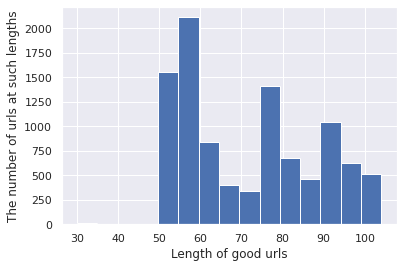

In [15]:
# Lets visualize this a bit
len_of_good_urls = [len(url) for url in good_urls]
len_of_bad_urls = [len(url) for url in bad_urls]

# plotting
plt.xlabel('Length of good urls')
plt.ylabel('The number of urls at such lengths')
plt.hist(len_of_good_urls, bins=15 )
plt.show() # It looks like most of the good urls are under the length of 100, with max length around 105. 

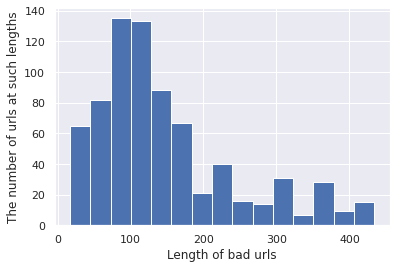

In [16]:
# plotting
plt.xlabel('Length of bad urls')
plt.ylabel('The number of urls at such lengths')
plt.hist(len_of_bad_urls, bins=15) 
plt.show() 
# It looks like most of the bad urls are more than length 90 or more.

In [17]:
# Need to find a cut off which maximizes both respective categories

In [18]:
count = 0
count2 = 0
for i in range(len(good_urls)):
    if len(good_urls[i]) >= 94:
        count +=1

for i in range(len(bad_urls)):
    if len(bad_urls[i]) >= 94:
        count2 +=1


In [19]:
print("Good:", count)
print("bad:", count2)
#Therefore, out of 10k, 515 of them are over lenght 100, and 502 out of 751 are over length 100. 

Good: 1326
bad: 502


# BAD URLS -- PATTERN #3 

Bad urls contain certain kind of words which are not present in good urls. <br>
These words seem to be trying to get information about the user, or get some form of personal information. 

In [20]:
# Define words which are in bad urls
bad_words = ["client_id", "signin", "logon", "login", "authorize", "admin"]

count=0
for url in good_urls:
    # Check if any of the words in the bad_words list are inside of that url
    if any(word in url for word in bad_words):
        count+=1
print(count)

5


In [21]:
# Do the same but now count if these bad words are in the bad urls
count=0
for url in bad_urls:
    # Check if any of the words in the bad_words list are inside of that url
    if any(word in url for word in bad_words):
        count+=1
print(count)

425


Only 5 good_urls have such words! <br>
This is a very low amount, and good for us (for lowering misclassification error) <br>

 <br> 
On the other hand, 425 bad urls have such words. Hence, it is a good characteristic for fraudeluent links. <br> 
Note that specifically for this dataset, if we just classified urls based on this pattern -- We would end up with a really good score. <br>
(By basically running through every url and if it doesn't contain a word in that list, it is automatically good). <br>
However, to generalize -- We will use all of the patterns we have discovered. 

# Heuristic Model 

I wanted to do as little data cleaning / pre-processing as possible before we ran the heuristic model. <br>
This is solely because from my understanding, this model should just be a quick classification on the url, as the urls are coming in. <br>
I will however remove the duplicates as they might skew the results.


## Our Heuristic Classifier Is a Pattern Based Classifier

It searches for the 3 patterns mentioned above, and based on those results, classifies the url as good or bad.

In [22]:
print("With Duplicates:", len(urls))
urls = urls.drop_duplicates()
print("without Duplicates:", len(urls))

With Duplicates: 10750
without Duplicates: 8558


In [23]:
df.head(2)

,label,url,url_length
0,1,http://www.tirumular.com/assets/adminpanel/js/...,234
1,1,http://mail.bpiexpressonline.org/bankofamerica...,178


In [24]:
# Heuristic classifier
def Heuristic_model(urls_df):
    
    heuristic_df = {}
    # Go thru urls and classify them as good or bad
    for url in urls_df["url"]:
        if url[0:5] == "http:":
            if (len(url) > 100) or any(word in url for word in bad_words):
                heuristic_df[url] = 1
            else:
                heuristic_df[url] = 0
        else:
            heuristic_df[url] = 0
    #Turn it into a pandas df
    df1 = pd.DataFrame.from_dict(heuristic_df, orient='index')
    df1 = df1.reset_index()
    df1.columns = ["url", "predicted_label"]
    
    # inner join on the distinct urls to get the true labels
    df1 = pd.merge(urls_df, df1, on=["url", "url"], how="inner")
    
    return df1

In [25]:
Heuristic_model = Heuristic_model(df) # We calculate the Precision, Recall, TP, FP, FN, etc at the end (below). 
Heuristic_model

,label,url,url_length,predicted_label
0,1,http://www.tirumular.com/assets/adminpanel/js/...,234,1
1,1,http://mail.bpiexpressonline.org/bankofamerica...,178,1
2,1,http://info.scienceoftheday.com/fcs40/c2.php?f...,76,0
3,1,http://accounts-google.i-love.xyz/servicelogin...,178,1
4,1,http://www.weebly.com/oauth/authorize?client_i...,378,1
...,...,...,...,...
10745,0,https://thewrap.cmail19.com/t/j-u-nttvly-wftkj...,53,0
10746,0,http://l.e.crainalerts.com/rts/go2.aspx?h=qggn...,92,0
10747,0,https://sable.madmimi.com/c/31047?id=gxfxgerfg...,86,0
10748,0,http://rss.cnn.com/~ff/rss/cnn_topstories?a=dr...,79,0


# ML Classifier Begins - Data Pre-Processing

In [26]:
print(len(df))
df.head(2)

10750


,label,url,url_length
0,1,http://www.tirumular.com/assets/adminpanel/js/...,234
1,1,http://mail.bpiexpressonline.org/bankofamerica...,178


In [27]:
# Drop duplicates
df = df.drop_duplicates()

###  Feature Engineering

After some research on a url, some of the features I have learned might be helpful are the following: <br>
- Length of the URL 
- Amount of Numbers in a URL
- Entropy of a URL
- NumParameters
- domain Extension
- amount of times %20 is present
- number of times @ is present
- if the url has an ip
- if the url has HTTP
- if the url has HTTPS
- if the url is live

These are the features we will try to create for our model. 


In [33]:
# Create the features
import math
def url_length(url):
    return len(url)

def nums_in_url(url):
    # Get all digits inside of the url and store it ina list
    digits = [i for i in url if i.isdigit()]
    return len(digits)

def url_entropy(url):
    url = url.strip()
    prob = [float(url.count(c)) / len(url) for c in dict.fromkeys(list(url))]
    entropy = sum([(p * math.log(p) / math.log(2.0)) for p in prob])
    return entropy

def num_parameters(url):
    params = url.split('&')
    return (len(params) - 1)

def num_Fragments(url):
    fragments = url.split('#')
    return len(fragments) - 1

def domain(url):
    domain = url.split('//')[-1].split('/')[0]
    return domain

def num_sub_domain(url):
    subdomains = url.split('http')[-1].split('//')[-1].split('/')
    return len(subdomains)-1

def domain_extension(url):
    domain = url.split('//')[-1].split('/')[0]
    ext = url.split('.')[-1].split('/')[0]
    return ext

def num_perecent20(url):
    return url.count("%20")

def num_AT_present(url):
    return url.count("@")

def url_has_http(url):
    return 'http:' in url

def url_has_https(url):
    return 'https:' in url

def url_contains_bad_words(url):
    # Define words which are in bad urls
    bad_words = ["client_id", "signin", "logon", "login", "authorize", "admin"]
    # Check if any of the words in the bad_words list are inside of that url
    if any(word in url for word in bad_words):
        return True
    else:
        return False

In [34]:
# Remove it as we added it for the Heuristic classifier. 
url_df = df.drop("url_length", axis = 1)

In [35]:
# Featurize the urls 
def featurize_urls(url_dataset):
    dict1 = {}
    for row in url_dataset["url"]:
        dict1[row] = [url_length(row), nums_in_url(row), url_entropy(row),num_parameters(row), num_Fragments(row), domain(row), num_sub_domain(row), domain_extension(row), 
                      num_perecent20(row), num_AT_present(row), url_has_http(row), url_has_https(row),url_contains_bad_words(row)]
    
    # Create it in a pandas dataframe
    df2 = pd.DataFrame.from_dict(dict1, orient='index')
    df2 = df2.reset_index()
    df2.columns =["url", 'url_length',"nums_in_url", "url_entropy", "num_parameters", "num_Fragments","domain", "num_sub_domain", "domain_extension", 
                  "num_perecent20", "num_AT_present",'num_http', 'num_https', 'has_bad_words']
    
    # inner join on the distinct urls to get the labels
    df2 = pd.merge(url_dataset, df2, on=["url", "url"], how="inner")
    return df2

In [36]:
data = featurize_urls(url_df)

In [37]:
data

,label,url,url_length,nums_in_url,url_entropy,num_parameters,num_Fragments,domain,num_sub_domain,domain_extension,num_perecent20,num_AT_present,num_http,num_https,has_bad_words
0,1,http://www.tirumular.com/assets/adminpanel/js/...,234,23,-4.934744,2,0,www.tirumular.com,10,php?cmd=zazgoagcvrfcaanbvefzborafpgfzzzrrfnnfv...,0,0,True,False,True
1,1,http://mail.bpiexpressonline.org/bankofamerica...,178,14,-4.717985,1,0,mail.bpiexpressonline.org,3,org,0,0,True,False,False
2,1,http://info.scienceoftheday.com/fcs40/c2.php?f...,76,21,-4.369399,0,0,info.scienceoftheday.com,8,php?focs,0,0,True,False,False
3,1,http://accounts-google.i-love.xyz/servicelogin...,178,0,-4.593546,9,0,accounts-google.i-love.xyz,1,xyz,0,0,True,False,True
4,1,http://www.weebly.com/oauth/authorize?client_i...,378,0,-4.313460,2,0,www.weebly.com,2,com,0,0,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8553,0,https://thewrap.cmail19.com/t/j-u-nttvly-wftkj...,53,2,-4.458843,0,0,thewrap.cmail19.com,3,com,0,0,False,True,False
8554,0,http://l.e.crainalerts.com/rts/go2.aspx?h=qggn...,92,1,-4.586965,1,0,l.e.crainalerts.com,2,aspx?h=qggnrx&tp=nkbxbaeranbovdajxvgjaafnrjazd...,0,0,True,False,False
8555,0,https://sable.madmimi.com/c/31047?id=gxfxgerfg...,86,5,-4.635713,0,0,sable.madmimi.com,2,com,0,0,False,True,False
8556,0,http://rss.cnn.com/~ff/rss/cnn_topstories?a=dr...,79,0,-4.408556,0,0,rss.cnn.com,3,com,0,0,True,False,False


### Dealing with Class Imbalance -- using SMOTE

In [38]:
# Maybe if we had more time, I can explore using NLP on the domain and subdomain features ( or some other form of label encoding
all_features = data.drop(axis=1, labels =["url", "domain", "domain_extension"])
all_targets = all_features.pop("label")
train_features , test_features, train_targets, test_targets = train_test_split(all_features, all_targets, test_size=0.2)

In [39]:
# import imbalance data library
from imblearn.over_sampling import SMOTE
from collections import Counter
smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(train_features, train_targets)

# Added approx. 6k more training examples! (for fruadulent rows)
print('Original dataset shape', Counter(train_targets))
print('Resample dataset shape', Counter(y_smote))

# WE use the resampled dataset for training. 
# NOTE that the testing data has not been changed.
train_features, train_targets = x_smote, y_smote

Original dataset shape Counter({0: 6276, 1: 570})
Resample dataset shape Counter({0: 6276, 1: 6276})


# Modelling & Training

In [40]:
# Initialize all models in a list
models = [DecisionTreeClassifier(max_depth=8),
          # SVC is overfitting like crazy, needs regularization
          SVC(C=1, decision_function_shape="ovo", verbose=True),
          RandomForestClassifier(max_depth=12, n_estimators=100),
          MLPClassifier(hidden_layer_sizes=(100,100),max_iter=1000,alpha=0.01,tol = 0.000000001, solver="lbfgs", verbose=True, activation = "tanh"),
          AdaBoostClassifier(n_estimators=200, learning_rate=0.05),
          GaussianNB(),
          QuadraticDiscriminantAnalysis(reg_param=0),
          GradientBoostingClassifier(verbose=True),
         ]
# Define all the model names
model_names = ["Decision Tree",
               "SVC",
               "Random Forest",
               "Neural Net",
               "Adaboost",
               "Gaussian Naive Bayes",
               "QDA",
               "Gradient Boosting Classifier"
              ]
# Print the data size
print("Training Data size: {}".format(train_features.shape))

# Loop over models instead of having separate cell per model
for name, model in zip(model_names, models):
    # Training and model accuracy
    model.random_state = 0
    print("Training Model :  {}".format(name))
    model.fit(train_features, train_targets)
    print("Done Training {}".format(name))
    test_score = model.score(test_features, test_targets) * 100
    train_score = model.score(train_features, train_targets) * 100
    
    # Predict Y values and see the TP, FP, et c(Using confusion matrix)
    y_pred = model.predict(test_features) # removed the predict.probabilities
    precision, recall, thresholds = metrics.precision_recall_curve(test_targets, y_pred)
    pr_auc = metrics.auc(recall, precision)
    CM = confusion_matrix(test_targets, y_pred)
    TN, FN, TP, FP = CM[0][0], CM[1][0],  CM[1][1], CM[0][1]
    print("{} Train Score : {}".format(name, train_score))
    print("{} Test Score : {}".format(name, test_score))
    print("PR-AUC: {}".format(pr_auc))
    print("# of False Positives: {}".format(FP))
    print("# of True Positives: {}".format(TP))
    print("# of False Negatives: {}".format(FN))
    print("~"*50)
    print("Model Done")
    print("~"*50)

print("*"*50)    
print("~"*50)
print("ALL MODELS DONE")
print("~"*50)
print("*"*50)

Training Data size: (12552, 11)
Training Model :  Decision Tree
Done Training Decision Tree
Decision Tree Train Score : 98.35882727852136
Decision Tree Test Score : 99.35747663551402
PR-AUC: 0.9605672842659025
# of False Positives: 5
# of True Positives: 128
# of False Negatives: 6
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Model Done
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training Model :  SVC
[LibSVM]Done Training SVC
SVC Train Score : 85.31708094327597
SVC Test Score : 97.89719626168224
PR-AUC: 0.8695486564628007
# of False Positives: 6
# of True Positives: 104
# of False Negatives: 30
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Model Done
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training Model :  Random Forest
Done Training Random Forest
Random Forest Train Score : 99.8565965583174
Random Forest Test Score : 100.0
PR-AUC: 1.0
# of False Positives: 0
# of True Positives: 134
# of False Negatives: 0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# RESULTS

In [41]:
print("~"*50)
print("Heuristic Model Results")
print("~"*50)
precision, recall, thresholds = metrics.precision_recall_curve(Heuristic_model["label"], Heuristic_model["predicted_label"])
pr_auc = metrics.auc(recall, precision)
CM = confusion_matrix(Heuristic_model["label"], Heuristic_model["predicted_label"])
TN, FN, TP, FP = CM[0][0], CM[1][0],  CM[1][1], CM[0][1]
print("PR-AUC: {}".format(pr_auc))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("# of False Positives: {}".format(FP))
print("# of True Positives: {}".format(TP))
print("# of False Negatives: {}".format(FN))
# Predict Y values and see the TP, FP, et c(Using confusion matrix)
print("~"*50)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Heuristic Model Results
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PR-AUC: 0.7821786293334227
Precision: [0.06986047 0.82568807 1.        ]
Recall: [1.         0.71904128 0.        ]
# of False Positives: 114
# of True Positives: 540
# of False Negatives: 211
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [42]:
print("~"*50)
print("ML Model -- Gradient Boosting Classifier")
print("~"*50)

# All values are from the last model, GB
precision, recall, thresholds = metrics.precision_recall_curve(test_targets, y_pred) 
pr_auc = metrics.auc(recall, precision)
CM = confusion_matrix(test_targets, y_pred)
TN, FN, TP, FP = CM[0][0], CM[1][0],  CM[1][1], CM[0][1]
print("{} Train Score : {}".format(name, train_score))
print("{} Test Score : {}".format(name, test_score))
print("PR-AUC: {}".format(pr_auc))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("# of False Positives: {}".format(FP))
print("# of True Positives: {}".format(TP))
print("# of False Negatives: {}".format(FN))
print("~"*50)
print("~"*50)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ML Model -- Gradient Boosting Classifier
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Gradient Boosting Classifier Train Score : 99.4980879541109
Gradient Boosting Classifier Test Score : 99.76635514018692
PR-AUC: 0.9856587390152043
Precision: [0.07827103 0.98507463 1.        ]
Recall: [1.         0.98507463 0.        ]
# of False Positives: 2
# of True Positives: 132
# of False Negatives: 2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


## Conclusion and Limitations

Thank you so much for the oppurtunity to participate in this. 
If I had more time, I would have loved to do some of the following: <br>
- Explore more into the synthetic examples made to up the "bad" class.
- I also would have tried to increase the non-ml made model accuracy by adding more patterns such as seeing if a link is live (by checking if theres a response signal), and more. 
- Do some more feature engineering, and Tune the ML models more with grid search to find the best possible parameters.
- Maybe explore baysian optimization to see if error is really as low as possible
<br>

Other than that, we can see the random forest classifier and GB had the most amount of success. 
I would have also loved to do an ensemble of the top 3 models and present that as the main model solution, 
just to lower the chances of false positives as much as possible.<br> 
Thank you once again for the great oppurtunity! 